In [10]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from matplotlib import rcParams
from ForceMapping import forceMapping as fm
from sklearn.preprocessing import MinMaxScaler
np.set_printoptions(suppress=True)

In [5]:
data_for_train = np.loadtxt('data_for_train.csv', delimiter=',')
data_for_train.shape

(7140, 40)

In [6]:
period = 140

In [7]:
Joint_pos = data_for_train[:,0:4]
Joint_tor = data_for_train[:,16:20]
RF_GRF = data_for_train[:,32:34]

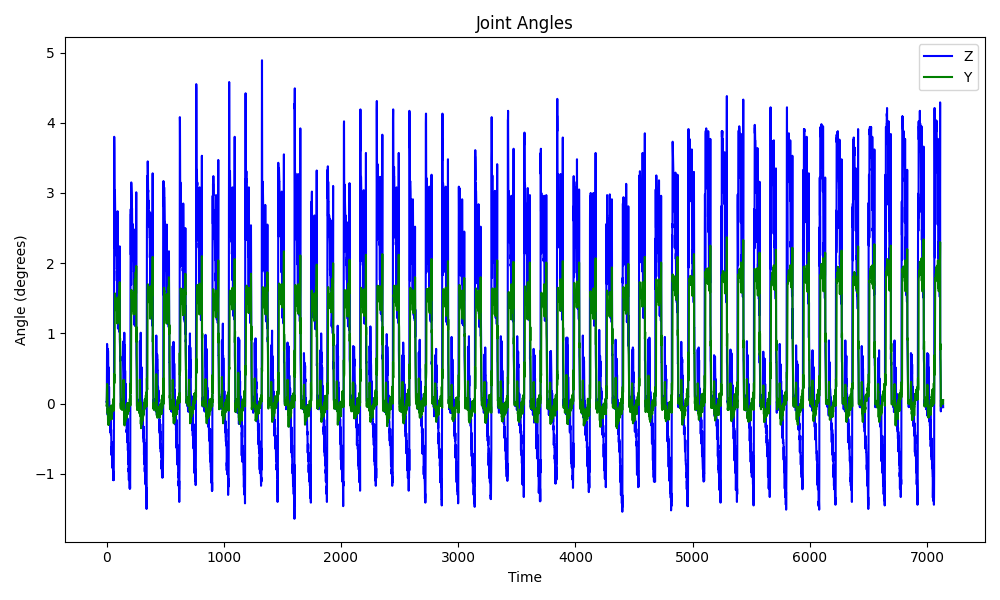

In [9]:
plot_foot_forces(RF_GRF)

### normalize the input data

In [11]:
# Create scaler and fit
scaler = MinMaxScaler(feature_range=(-1, 1))
Joint_tor_scaled = scaler.fit_transform(Joint_tor.reshape(-1,1)).reshape(-1,4)

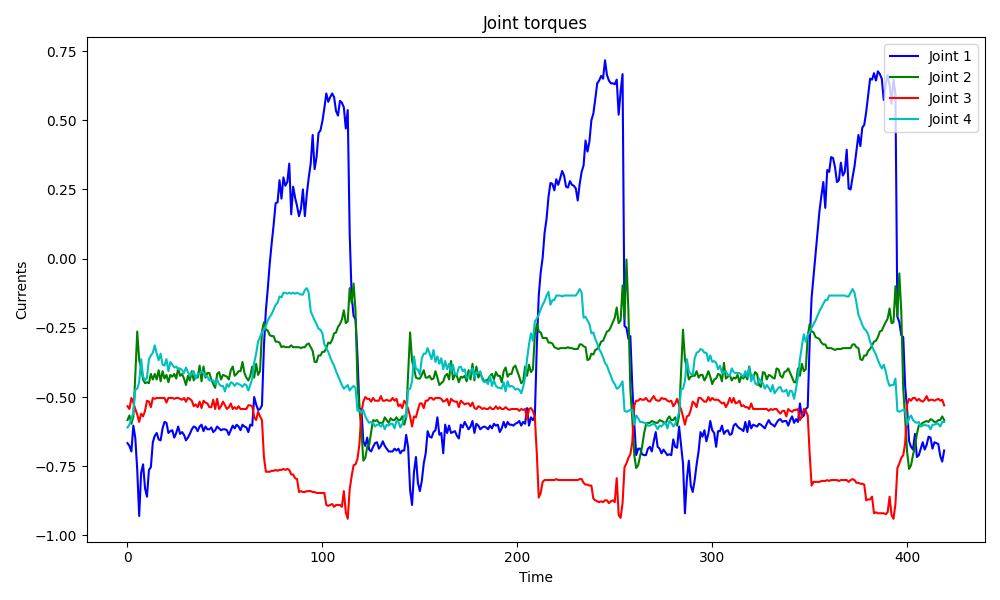

In [112]:
plt.close('all')
plot_joint_angles(Joint_tor_scaled[:period*3,:], title="Joint torques", xlabel="Time", ylabel="Currents")


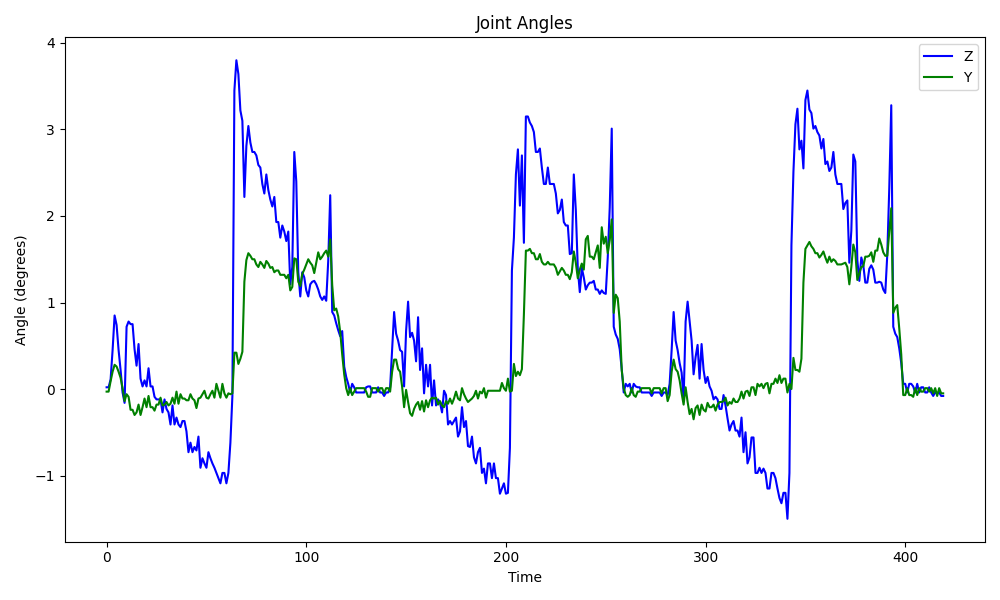

In [114]:
plt.close('all')
plot_foot_forces(RF_GRF[:period*3,:])

NameError: name 'ESN' is not defined

### Rearrange the input and output data by limb configuration (one period 140 points)

In [28]:
joint_tor_stacked = rearrange_and_stack(Joint_tor_scaled, period)

In [30]:
RF_GRF_stacked = rearrange_and_stack(RF_GRF, period)

In [31]:
RF_GRF_stacked.shape

(140, 2, 51)

In [32]:
joint_tor_stacked.shape

(140, 4, 51)

(-1.0, 1.0)

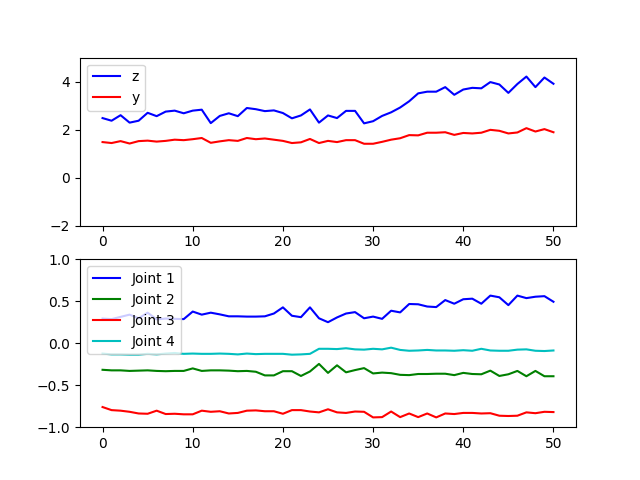

In [47]:
plt.close('all')
selected_id = 80
RF_GRF_stacked[0,:,:].shape
plt.subplot(2,1,1)
plt.plot(RF_GRF_stacked[selected_id,0,:], color='b',label='z')
plt.plot(RF_GRF_stacked[selected_id,1,:], color='r', label='y')
plt.ylim([-2,5])
plt.legend()
plt.subplot(2,1,2)
joints = ['Joint 1', 'Joint 2', 'Joint 3', 'Joint 4']
colors = ['b', 'g', 'r', 'c']  # 不同颜色区分关节
for i in range(4):
    plt.plot(joint_tor_stacked[selected_id,i,:],color=colors[i], label=joints[i], linewidth=1.5)
plt.legend()

plt.ylim([-1,1])

### Whether the mapping from joint torque to GRF perseve good linearity

In [80]:
mat_for_x = []
mat_for_residual = []

for i in range(period):
    A = joint_tor_stacked[i,:,:].T
    y = RF_GRF_stacked[i,:,:].T
    X, residuals, rank, s = np.linalg.lstsq(A, y, rcond=None)
    mat_for_x.append(X)
    mat_for_residual.append(residuals)


In [90]:
residual_stacked = np.stack(mat_for_residual, axis=0)


(140, 2)

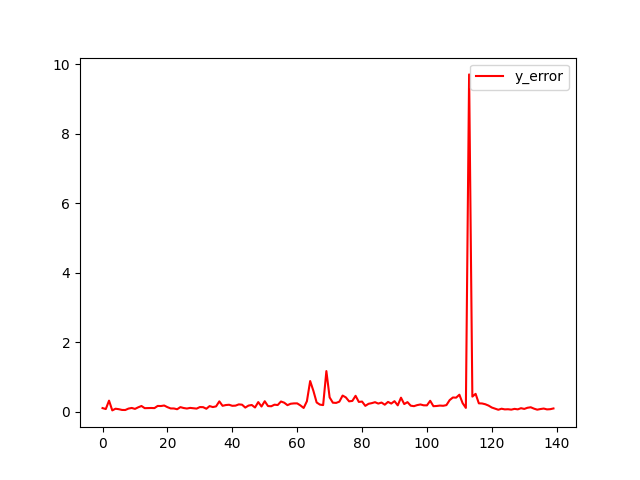

In [115]:
plt.close('all')
# plt.plot(residual_stacked[:,0], color='b',label='z_error')
plt.plot(residual_stacked[:,1], color='r', label='y_error')
plt.legend()
plt.show()

In [117]:
selected_id = 113
A = joint_tor_stacked[selected_id,:,:].T
y = RF_GRF_stacked[selected_id,:,:].T
X, residuals, rank, s = np.linalg.lstsq(A, y, rcond=None)
residuals

array([80.50671455,  9.71195608])

(-1.0, 1.0)

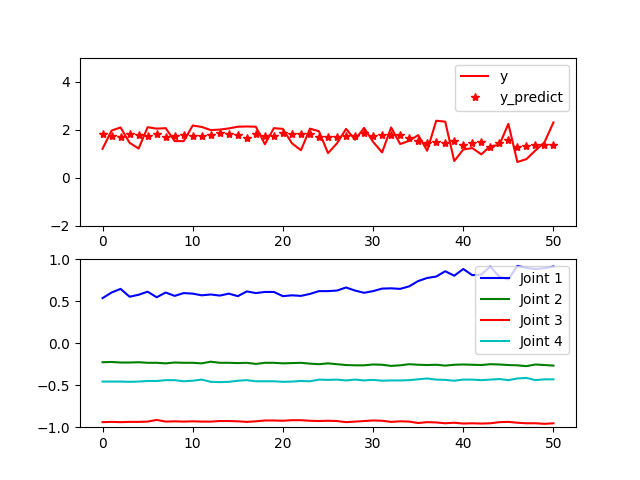

In [118]:
plt.close('all')
plt.subplot(2,1,1)
# plt.plot(RF_GRF_stacked[selected_id,0,:], color='b',label='z')
plt.plot(RF_GRF_stacked[selected_id,1,:], color='r', label='y')

# plt.plot(A@X[:,0], '*b',label='z_predict')
plt.plot(A@X[:,1], '*r', label='y_predict')
plt.ylim([-2,5])
plt.legend()
plt.subplot(2,1,2)
joints = ['Joint 1', 'Joint 2', 'Joint 3', 'Joint 4']
colors = ['b', 'g', 'r', 'c']  # 不同颜色区分关节
for i in range(4):
    plt.plot(joint_tor_stacked[selected_id,i,:],color=colors[i], label=joints[i], linewidth=1.5)
plt.legend()

plt.ylim([-1,1])

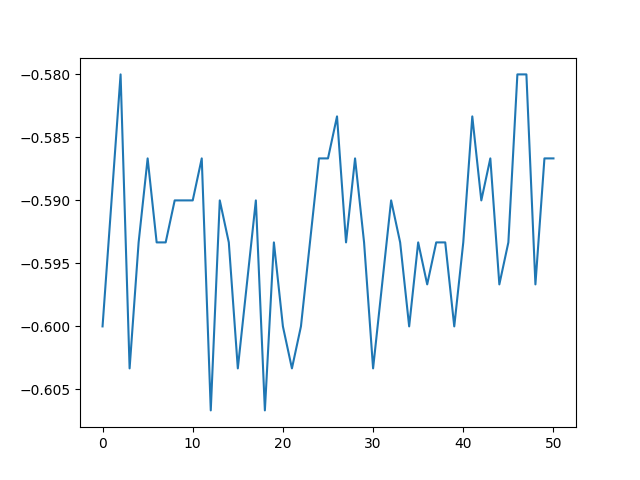

In [111]:
plt.close('all')
plt.plot(joint_tor_stacked[63,0,:])
plt.show()

In [26]:
def rearrange_and_stack(Joint_tor_scaled, period):
    joint_tor_rearrange = []
    for i in range(int(Joint_tor_scaled.shape[0] / period)):
        joint_tor_rearrange.append(Joint_tor_scaled[i*period:(i+1)*period, :])
    joint_tor_stacked = np.stack(joint_tor_rearrange, axis=-1)
    return joint_tor_stacked

In [2]:
def plot_joint_angles(joint_angles, title="Joint Angles", xlabel="Time", ylabel="Angle (degrees)"):
    """
    绘制四关节角度信号
    
    参数:
        joint_angles: 形状为(n,4)的numpy数组，包含四个关节的角度数据
        title: 图表标题 (默认: "Joint Angles")
        xlabel: x轴标签 (默认: "Time")
        ylabel: y轴标签 (默认: "Angle (degrees)")
    """
    # 检查输入数据
    if not isinstance(joint_angles, np.ndarray) or joint_angles.shape[1] != 4:
        raise ValueError("输入数据必须是形状为(n,4)的numpy数组")
    
    # 创建图形和轴
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # 时间轴 (假设是等间隔采样)
    time = np.arange(joint_angles.shape[0])
    
    # 为每个关节绘制曲线
    joints = ['Joint 1', 'Joint 2', 'Joint 3', 'Joint 4']
    colors = ['b', 'g', 'r', 'c']  # 不同颜色区分关节
    
    for i in range(4):
        ax.plot(time, joint_angles[:, i], 
                color=colors[i], 
                label=joints[i],
                linewidth=1.5)
    
    # 添加图例和标签
    ax.legend(loc='upper right')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    # # 添加网格
    # ax.grid(True, linestyle='--', alpha=0.6)
    
    # 自动调整布局
    plt.tight_layout()
    
    # 显示图形

In [3]:
def plot_foot_forces(joint_angles, title="Joint Angles", xlabel="Time", ylabel="Angle (degrees)"):
    """
    绘制四关节角度信号
    
    参数:
        joint_angles: 形状为(n,4)的numpy数组，包含四个关节的角度数据
        title: 图表标题 (默认: "Joint Angles")
        xlabel: x轴标签 (默认: "Time")
        ylabel: y轴标签 (默认: "Angle (degrees)")
    """
    # 检查输入数据
    if not isinstance(joint_angles, np.ndarray) or joint_angles.shape[1] != 2:
        raise ValueError("输入数据必须是形状为(n,4)的numpy数组")
    
    # 创建图形和轴
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # 时间轴 (假设是等间隔采样)
    time = np.arange(joint_angles.shape[0])
    
    # 为每个关节绘制曲线
    joints = ['Z', 'Y']
    colors = ['b', 'g']  # 不同颜色区分关节
    
    for i in range(2):
        ax.plot(time, joint_angles[:, i], 
                color=colors[i], 
                label=joints[i],
                linewidth=1.5)
    
    # 添加图例和标签
    ax.legend(loc='upper right')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    # # 添加网格
    # ax.grid(True, linestyle='--', alpha=0.6)
    
    # 自动调整布局
    plt.tight_layout()
    
    # 显示图形